## Exploring forecasting various home price metric with pytorch
see: 
- https://github.com/jdb78/pytorch-forecasting
- https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html 


In [2]:
# imports for training
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# import dataset, network to train and metric to optimize
from pytorch_forecasting import (
    Baseline,
    TimeSeriesDataSet,
    TemporalFusionTransformer,
    QuantileLoss,
)
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer, NaNLabelEncoder
from capston_db_conn import db_conn
import torch

conn = db_conn()
# print(conn)

# standard imports
import numpy as np
import pandas as pd
import warnings

In [3]:
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

#### Load Data

In [4]:
#use the pickle file for 2019 data instead
data = pd.read_pickle("dataraw_2019.pkl")

# TODO: add time_idx in morning

In [5]:
data.head()

,state_fips,county_fips,year,debt_ratio_low,debt_ratio_high,corp_income_tax_low,corp_income_tax_high,income_tax_low,income_tax_high,11_avg_annual_employee_pct_chg,...,hs_diploma_pct,some_college_lessthan_1yr_pct,some_college_greaterthan_1yr_pct,bachelor_degree_pct,master_degree_pct,professional_degree_pct,doctorate_degree_pct,occupied_units_pct,vacant_units_pct,annual_change_pct
0,1.0,01015,2019,1.2800,1.475,6.5,6.5,2.0,5.0,0.000000,...,0.197808,0.036301,0.115479,0.079944,0.034479,0.009471,0.010404,0.829527,0.170473,3.43
1,1.0,01043,2019,1.6400,1.905,6.5,6.5,2.0,5.0,0.000000,...,0.162496,0.055355,0.109779,0.070850,0.033366,0.004083,0.002017,0.838823,0.161177,4.19
2,1.0,01049,2019,1.1450,1.325,6.5,6.5,2.0,5.0,100.000000,...,0.196132,0.048131,0.072840,0.051641,0.029072,0.003174,0.000000,0.787192,0.212808,4.22
3,1.0,01055,2019,1.5275,1.760,6.5,6.5,2.0,5.0,0.000000,...,0.179714,0.061202,0.117769,0.073571,0.030176,0.009074,0.008126,0.836966,0.163034,3.60
4,1.0,01073,2019,0.8950,1.100,6.5,6.5,2.0,5.0,1.408451,...,0.156648,0.038477,0.105712,0.139755,0.061027,0.023885,0.012866,0.854944,0.145056,3.75


#### Create Dataset & Dataloaders

In [9]:
# define the dataset, i.e. add metadata to pandas dataframe for the model to understand it
max_encoder_length = 60
max_prediction_length = 12
training_cutoff = data["time_idx"].max() - max_prediction_length  # day for cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",  # column name of time of observation
    target="median_sale_price",  # column name of target to predict
    group_ids=["region", "property_type"],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID
    static_categoricals=["region","property_type"],
    static_reals=[],
    # covariates known and unknown in the future to inform prediction
    time_varying_known_categoricals=[],
    time_varying_known_reals=[], # this is where tax rate would go
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "median_sale_price",
        "median_list_price",
        "median_ppsf",
        "median_list_ppsf",
        "homes_sold",
        "pending_sales",
        "new_listings",
        "inventory",
        "months_of_supply",
        "median_dom",
        "avg_sale_to_list",
        "sold_above_list",
        "off_market_in_two_weeks",
    ],
    add_relative_time_idx=True,
    allow_missing_timesteps=True,
    categorical_encoders={"region":NaNLabelEncoder(add_nan=True)}
)
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    # add_target_scales=True,
    # add_encoder_length=True,
# )


In [10]:
#training.get_parameters() 

In [11]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    predict=True,
    min_prediction_idx=training.index.time.max() + 1,
    stop_randomization=True,
)

In [12]:
# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=2
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=2 # double check factor of 10 will work
)

#### Baseline Model for comparison

In [13]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()
# last was 48131.4375

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


48131.4375

#### Find Optimal Learning Rate

In [16]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=3,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 51.3k


/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
Finding best initial lr: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]
Restoring states from the checkpoint path at /Users/ianbyrne/Dev/CapstoneTeamJim/ian-scratchpads/.lr_find_f0d7de0c-7592-44a4-bb29-ed70f26c647e.ckpt


suggested learning rate: 0.06760829753919811


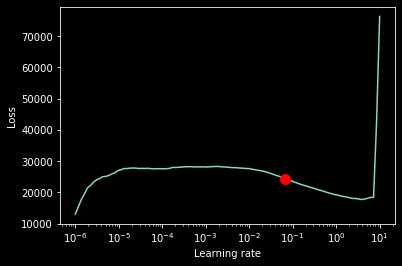

In [17]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

#### Train Model

In [18]:
# configure network and trainer
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
# define network to train - the architecture is mostly inferred from the dataset,
# so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=3, # play around with this param - can go up to 4 depending on sizeof data 
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=0,
    # optimizer parameters
    learning_rate=0.03, #change back to best_tft
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 138.6k


In [20]:
# old learning rate finder

# # find the optimal learning rate
# res = trainer.tuner.lr_find(
#     tft, 
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     early_stop_threshold=1000.0,
#     max_lr=0.3,
# )
# # and plot the result - always visually confirm that the suggested learning rate makes sense
# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()


In [21]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 53.7 K
3  | prescalers                         | ModuleDict                      | 448   
4  | static_variable_selection          | VariableSelectionNetwork        | 294   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 29.8 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Sanity Checking: 0it [00:00, ?it/s]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 0:  91%|█████████ | 30/33 [00:20<00:02,  1.48it/s, loss=1.12e+04, v_num=3, train_loss_step=7.82e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 1:  91%|█████████ | 30/33 [00:51<00:05,  1.73s/it, loss=8.1e+03, v_num=3, train_loss_step=7.55e+3, val_loss=1.6e+4, train_loss_epoch=1.45e+4] 

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 2:  91%|█████████ | 30/33 [01:23<00:08,  2.77s/it, loss=7.22e+03, v_num=3, train_loss_step=1.08e+4, val_loss=1.37e+4, train_loss_epoch=8.16e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 3:  91%|█████████ | 30/33 [01:55<00:11,  3.86s/it, loss=7.33e+03, v_num=3, train_loss_step=7.85e+3, val_loss=1.31e+4, train_loss_epoch=7.2e+3] 

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 3: 100%|██████████| 33/33 [02:07<00:00,  3.87s/it, loss=7.33e+03, v_num=3, train_loss_step=7.85e+3, val_loss=1.33e+4, train_loss_epoch=7.25e+3]


#### Hyperparamter Tuning
- uses optuna: https://optuna.org/

In [22]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [20]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(2, 16), # defaults were 8-128
    hidden_continuous_size_range=(2, 16), # defaults were 8-128
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

[I 2022-04-02 14:15:25,336] A new study created in memory with name: no-name-c594b069-0437-4386-b02d-f58b7fb0fa34
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda

In [ ]:
# show best hyperparameters
print(study.best_trial.params)

#### Evaluation

In [23]:
# # load the best model according to the validation loss
# # (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [24]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader) #change back to best_tft
(actuals - predictions).abs().mean()

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


tensor(45440.6016)

In [25]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True) #change back to best_tft

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


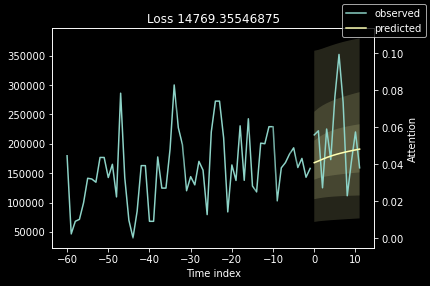

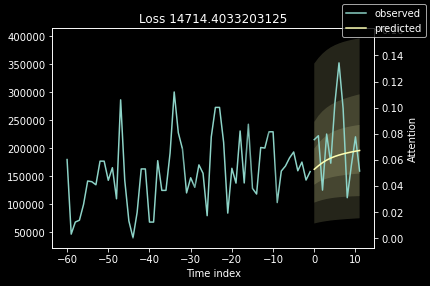

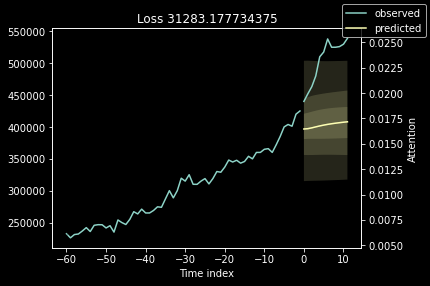

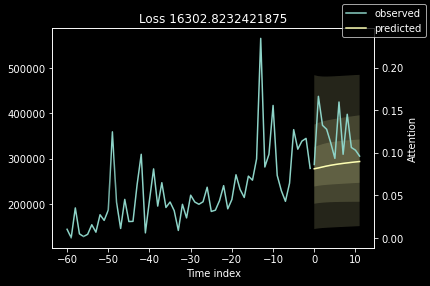

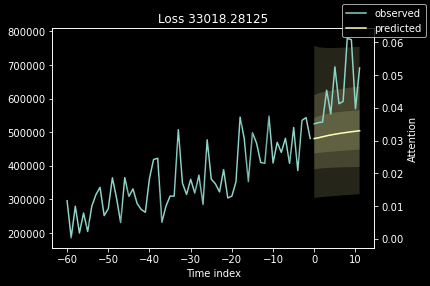

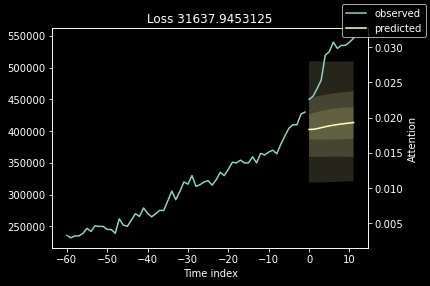

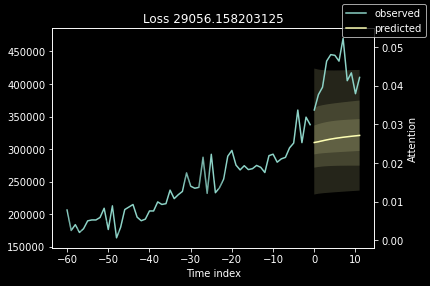

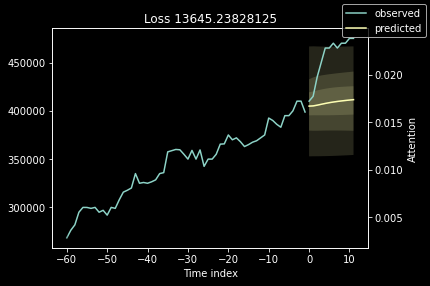

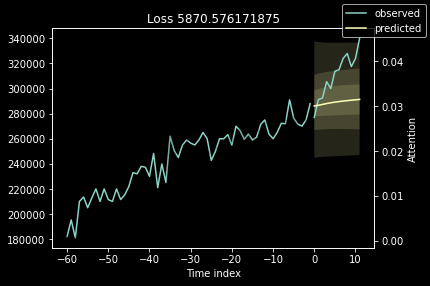

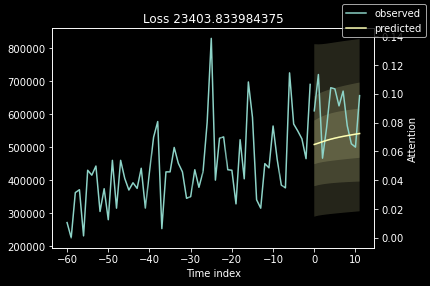

In [26]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True); #change back to best_tft

#### Worst Performers
- various metrics to choose from: https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.metrics.html#module-pytorch_forecasting.metrics

In [ ]:
# # calcualte metric by which to display
# predictions = best_tft.predict(val_dataloader)
# mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
# indices = mean_losses.argsort(descending=True)  # sort losses
# for idx in range(10):  # plot 10 examples
#     best_tft.plot_prediction(
#         x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
#     );

#### Actuals vs predictions by variable

In [ ]:
# predictions, x = best_tft.predict(val_dataloader, return_x=True)
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

#### Predict on selected data

In [ ]:
# change args to variables 
county = None
prop_type = None
# fips = None

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

#### Model Interpretation

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
 # can look at partial dependency here later